## Objective
Run algorithm on spikeinterface recording

si_rec.ipynb -> si_rec2.ipynb: making code easier to navigate and better spike splitting

## General setup

In [1]:
%load_ext autoreload

In [2]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.signal import find_peaks

from tqdm import tqdm

%autoreload 2
from src.prop_signal import v1_4 as ps_alg
from src import plot
from src.recording import Recording
from src.sorters.prop_signal import PropSignal, PropUnit
from src.sorters.kilosort import Kilosort
from src.comparison import Comparison
from src import utils


In [3]:
RECORDING = utils.rec_si()
CROSS_TIMES = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_5_full/crossings.npy", allow_pickle=True)
CROSS_AMPS = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_5_full/amplitudes.npy", allow_pickle=True)
CHANS_RMS = utils.chans_rms_si()

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


Recording does not have scaled traces. Setting gain to 0.195


## Functions and classes

### Merging

In [ ]:
# region Electrode overlap
def get_elec_overlap(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values
    _, overlap_a, overlap_b = np.intersect1d(elec_a, elec_b, return_indices=True, assume_unique=True)
    return overlap_a, overlap_b


def score_elec_overlap(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values

    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    num_overlap = len(overlap_a)
    overlap_score = num_overlap / (len(elec_a) + len(elec_b) - num_overlap)
    return num_overlap, overlap_score * 100
# endregion

# region Sequence order overlap
def get_latency_pairs(latencies: np.ndarray):
    if latencies.size == 1:
        return latencies

    pairs = []
    for i in range(len(latencies)):
        for j in range(i+1, len(latencies)):
            diff  = latencies[i] - latencies[j]
            pairs.append(diff)
            
    return np.asarray(pairs)


def score_seq_order(prop_a, prop_b):
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    if overlap_a.size == 0:
        return np.nan

    latencies_a = prop_a.latency.values[overlap_a]
    latencies_b = prop_b.latency.values[overlap_b]
    # sums = np.sum(latencies_a) + np.sum(latencies_b)
    # if sums < 0.0001:
    #     return 0
    
    # Pairs
    # pairs_a = get_latency_pairs(latencies_a)
    # pairs_b = get_latency_pairs(latencies_b)
    # seq_score = np.sum(np.abs(pairs_a - pairs_b))
    # return seq_score / overlap_a.size

    # Deviation
    if overlap_a.size == 1:
        return 0    
    rel_latencies_a = latencies_a[1:] - latencies_a[0]
    rel_latencies_b = latencies_b[1:] - latencies_b[0]
    return np.mean(np.abs(rel_latencies_a - rel_latencies_b))
# endregion

# region Prop times and amps
def get_prop_times_and_amps(prop):
    """_summary_
    For one propagations
    
    ref = crossing of first/anchor electrode in prop
    tar = crossing of another electrode in prop

    Args:
        prop (_type_): _description_

    Returns:
        _type_: _description_
    """

    coactivations_min = max(COACTIVATIONS_N_MIN, COACTIVATIONS_P_MIN/100 * len(prop))

    if len(prop) < coactivations_min:
        return np.array([]), np.array([np.nan for _ in range(len(prop))])
    
    ref_elec = prop.ID[0]
    ref_cross_times = CROSS_TIMES[ref_elec]
    ref_cross_amps = CROSS_AMPS[ref_elec]
    
    propagating_data = {}  # (ref_time, ref_amp) : [(tar1_elec, tar1_amp), (tar2_elec, tar2_amp), ...]
    for tar_elec in prop.ID[1:]:
        tar_cross_times = CROSS_TIMES[tar_elec]
        tar_cross_amps = CROSS_AMPS[tar_elec]
        
        for ref_time, ref_amp in zip(ref_cross_times, ref_cross_amps):
            # Find closest target cross
            i_tar = np.searchsorted(tar_cross_times, ref_time, side="left")
            
            # Count as coactivation if within PROP_AFTER
            if i_tar < len(tar_cross_times) and tar_cross_times[i_tar] <= ref_time + PROP_AFTER:
                ref = (ref_time, ref_amp)
                tar = (tar_elec, tar_cross_amps[i_tar])
                if ref not in propagating_data:
                    propagating_data[ref] = [tar]
                else:
                    propagating_data[ref].append(tar)
                    
    keys = list(propagating_data.keys())
    ref_times = [k[0] for k in keys]
    order = np.argsort(ref_times)
        
    propagating_times = []
    propagating_amps = {elec: [] for elec in prop.ID.values}  # elec : amps
    last_ref_time = -np.inf
    for idx in order:
        
        ref_time, ref_amp = keys[idx]
        tars = propagating_data[keys[idx]]
        if len(tars) + 1 < coactivations_min:  # +1 since being in list counts as 2 coactivations
            continue
        
        if ref_time <= last_ref_time + ISI_VIOL:  # ISI violation
            continue
        last_ref_time = ref_time
        
        propagating_times.append(ref_time)
        propagating_amps[ref_elec].append(ref_amp)
        for elec, amp in tars:
            propagating_amps[elec].append(amp)
        
    propagating_amps = np.array([np.mean(amps) for amps in propagating_amps.values()])
    
    return propagating_times, propagating_amps
        

def get_propagating_times_and_amps_all():
    # For all propagations
    propagating_times = []
    propagating_amps = []
    
    for prop in tqdm(propagations):
        prop_times, prop_amps = get_prop_times_and_amps(prop)
        propagating_times.append(prop_times)
        propagating_amps.append(prop_amps)
        
    return propagating_times, propagating_amps
# endregion

# region Relative amplitude
def score_rel_amp(idx_a, idx_b):
    """_summary_

    Args:
        idx_a (_type_): _description_
        idx_b (_type_): _description_
    """
    prop_a = propagations[idx_a]
    prop_b = propagations[idx_b]
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    
    if overlap_a.size == 0:
        return np.nan
    
    amps_a = propagating_amps[idx_a][overlap_a]
    amps_b = propagating_amps[idx_b][overlap_b]
    
    rel_elec = np.argmax(amps_a)  # Which electrode to have amps relative to
    rel_amps_a = amps_a / amps_a[rel_elec]
    rel_amps_b = amps_b / amps_b[rel_elec]
        
    # print(prop_a.ID.values[overlap_a])
    # print(prop_b.ID.values[overlap_b])
        
    # print(amps_a)
    # print(amps_b)
        
    # print(overlap_a[rel_elec])
    # print(rel_amps_a)
    # print(rel_amps_b)
        
    diff = np.abs(rel_amps_a - rel_amps_b)
    return np.sum(diff) / diff.size
# endregion

# region Actual merging
def get_pair_merge_scores(i_a, i_b):
    prop_a = propagations[i_a]
    prop_b = propagations[i_b]

    elec_score_n, elec_score_p = score_elec_overlap(prop_a, prop_b)
    seq_score = score_seq_order(prop_a, prop_b)
    rel_amp_score = score_rel_amp(i_a, i_b)
    
    return elec_score_n, elec_score_p, seq_score, rel_amp_score

def get_merge_scores():
    merge_scores = []
    ind_a, ind_b = np.triu_indices(len(propagations), k=1)
    for i_a, i_b in zip(ind_a, ind_b):
        merge_scores.append(get_pair_merge_scores(i_a, i_b))
    return np.asarray(merge_scores)


def merge(dist_max, return_times=False, isi_viol=1.5):
    linkage_m = linkage(pdist, method=MERGE_METHOD)
    clusters = fcluster(linkage_m, dist_max, criterion=MERGE_CRITERION)
    
    propagations_merged = {}
    for i, c in enumerate(clusters):
        if c not in propagations_merged:
            propagations_merged[c] = [propagations[i]]
        else:
            propagations_merged[c].append(propagations[i])
          
    # IDK why pms are sorted by cluster ID
    # pm_order = sorted(c for c in propagations_merged.keys())
    # propagations_merged = [propagations_merged[c] for c in pm_order]
    
    # Sort pms by first electrode ID
    pm_ids = []
    elec_ids = []
    for p in propagations_merged.keys():
        pm_ids.append(p)
        elec_ids.append(min(prop.ID[0] for prop in propagations_merged[p]))
    pm_order = [pm_ids[e] for e in np.argsort(elec_ids)]
    propagations_merged = [propagations_merged[o] for o in pm_order]
        
    # Get spike times
    if not return_times:
        return propagations_merged
    else:
         # Get which propagation belongs to which merge 
        propagating_times_merged = {}
        for i, c in enumerate(clusters): 
            if c not in propagating_times_merged:
                propagating_times_merged[c] = propagating_times[i][:]
            else:
                propagating_times_merged[c].extend(propagating_times[i])
                
        # Sort propagation times and prevent ISI violations
        propagating_times_merged_sorted = []
        for c in pm_order:
            pu_times = propagating_times_merged[c]  # pu = propagations un-properly formatted 
            pu_times = np.sort(pu_times)
            
            last_time = pu_times[0]
            pm_times = [last_time]
            
            for t in range(1, pu_times.size):
                time = pu_times[t]
                if time - last_time > isi_viol:
                    pm_times.append(time)
                    last_time = time
            propagating_times_merged_sorted.append(np.array(pm_times))
    
        return propagations_merged, propagating_times_merged_sorted
# endregion

### Spike sorting

In [ ]:
def df_to_prop_idx(df):
    # pandas dataframe to idx in variable "propagations"
    for idx in range(len(propagations)):
        prop = propagations[idx]
        if len(df.ID) == len(prop.ID) and np.all(df.ID == prop.ID):
            return idx
    return None


def plot_sharing_props(ref_idx, vmax=None, ylim=None, chans_rms=None):
    # Two props are sharing if #spikes_same_frame/#ref_spikes >= OVERLAP_MIN
    print(ref_idx)
    ref_unit = prop_signal[ref_idx]
    kwargs = ref_unit.plot(vmax=vmax, ylim=ylim, chans_rms=chans_rms, return_kwargs=True)
    print(f"#spikes: {len(ref_unit)}")
    print(f"#not_unique/#ref_spikes: {overlap_ratios[ref_idx]:.3f}")
    print(f"#sharing units: {counts[ref_idx]}")
    ref_prop_ind = [df_to_prop_idx(df) for df in ref_unit.df]
        
    for comp_idx in range(len(prop_signal)):
        share_score = overlap_matrix[ref_idx, comp_idx]
        if share_score >= OVERLAP_MIN:
            print("\n"+"-"*50+"\n")
            print(comp_idx)
            comp_unit = prop_signal[comp_idx]
            comp_unit.plot(**kwargs)
            print(f"#spikes: {len(comp_unit)}\n#not_unique/#ref_spikes {share_score:.3f}")
            
            merge_elec_n = np.zeros((len(ref_prop_ind), len(comp_unit.df)), dtype=int)
            merge_elec_p = np.zeros_like(merge_elec_n, dtype=float)
            merge_seq = np.zeros_like(merge_elec_n, dtype=float)
            merge_rel = np.zeros_like(merge_elec_n, dtype=float)
            
            for r, ref_prop_idx in enumerate(ref_prop_ind):
                print(ref_unit.df[r].ID[0])
                for c, df in enumerate(comp_unit.df):
                    # elec_n, elec_p, seq, rel = get_pair_merge_scores(ref_prop_idx, df_to_prop_idx(df))
                    # merge_elec_n[r, c] = elec_n
                    # merge_elec_p[r, c] = elec_p
                    # merge_seq[r, c] = seq
                    # merge_rel[r, c] = rel
                    print_merge_scores(get_pair_merge_scores(ref_prop_idx, df_to_prop_idx(df)))
                    
            # merge_scores = np.array(merge_scores)
            # merge_means = np.mean(merge_scores, axis=0)
            # merge_stds = np.std(merge_scores, axis=0)
            # print_merge_scores(merge_means)
        
        
def print_merge_scores(merge_scores):
    print(f"Elec overlap: {merge_scores[0]} elecs = {merge_scores[1]:.1f}%")
    print(f"Sequence order score: {merge_scores[2]:.3f}")
    print(f"Rel amplitude score: {merge_scores[3]:.3f}")
    print()

## Channel crossings sanity check

In [ ]:
np.argsort([-len(c) for c in CROSS_TIMES])

In [ ]:
# Plot cross times on one channel
CHAN = 219
N = 300

N_BEFORE = 60
N_AFTER = 60

np.random.seed(231)
##
traces = [] 
for _ in range(N):
    time_ms = np.random.choice(CROSS_TIMES[CHAN])
    time = int(time_ms * RECORDING.get_sampling_frequency())
    trace = RECORDING.get_traces_filt(time-N_BEFORE, time+N_AFTER, CHAN).flatten()
    
    plt.plot(trace, color="black", alpha=0.01)
    
    traces.append(trace)
traces = np.stack(traces)
trace_mean = np.mean(traces, axis=0)
plt.plot(trace_mean, color="black")

plt.show()

## Form candidate cohorts

In [5]:
# Plot distribution of crossings on each channel
num_crossings = np.array([len(c) for c in CROSS_TIMES])
# plt.title("Number of 5RMS threshold crossings on each channel")
# plt.hist(num_crossings, range=(0, 50000), bins=40)
# plt.ylabel("Number of channels")
# plt.xlabel("Number of 5RMS threshold crossings")
# plt.xlim(0, 50000)
# plt.show()

MIN_PROP_SPIKES = 1 * 15 * 60  # min_firing_rate * mins * 60_seconds_per_min
num_lower = np.sum(num_crossings < MIN_PROP_SPIKES)
print(f"{num_lower}/{len(num_crossings)} electrodes have fewer than {MIN_PROP_SPIKES} threshold crossings. {len(num_crossings) - num_lower} have greater.")

23/248 electrodes have fewer than 900 threshold crossings. 225 have greater.


In [6]:
candidate_cohorts = ps_alg.scan_reference_electrode(CROSS_TIMES, sampling_freq=30, min_prop_spikes=MIN_PROP_SPIKES, min_ccg_ratio=0.5,
                                                    ccg_before=1.5, ccg_after=1.5, ccg_small_window=0.5, ccg_big_window=2)

Scanning reference electrodes ...


 19%|█▊        | 46/248 [00:58<04:17,  1.27s/it] Process ForkPoolWorker-9:
Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Process ForkPoolWorker-3:
Process ForkPoolWorker-14:
Process ForkPoolWorker-6:
Process ForkPoolWorker-11:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-10:
Process ForkPoolWorker-8:
Process ForkPoolWorker-15:
Process ForkPoolWorker-18:
Process ForkPoolWorker-1:
Process ForkPoolWorker-16:
Process ForkPoolWorker-12:
Process ForkPoolWorker-5:
Process ForkPoolWorker-20:
Process ForkPoolWorker-7:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mea/anaconda3/envs/prop/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most rece

KeyboardInterrupt: 

## Form propagations

In [ ]:
MIN_COCS_P_VALUES = range(0, 100)
##
nums_props = []

means_lens = []
stds_lens = []

means_durations = []
stds_durations = []
for min_cocs_p in MIN_COCS_P_VALUES:
    electrode_cohorts = ps_alg.rescan_candidate_cohorts(candidate_cohorts, max_latency=0.5,
                                                        min_cocs_n=0, min_cocs_p=min_cocs_p,
                                                        min_cocs_2_p=50)
    propagations = ps_alg.get_propagations(electrode_cohorts, min_duration=0.001)

    prop_lens = [len(p) for p in propagations]
    nums_props.append(len(prop_lens))

    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))

        prop_durations = [PropSignal.get_sequence_duration(p) for p in propagations]
        means_durations.append(np.mean(prop_durations))
        stds_durations.append(np.std(prop_durations))
    else:
        means_lens.append(0)
        stds_lens.append(0)

        means_durations.append(0)
        stds_lens.append(0)

plt.title("Num. propagations based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Num. propagations")
plt.scatter(MIN_COCS_P_VALUES, nums_props)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, max(nums_props)+1)
plt.show()

plt.title("Mean ± STD length of propagation based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Length")
plt.scatter(MIN_COCS_P_VALUES, means_lens)
y_max = max(means_lens)+3
for thresh, mean, std in zip(MIN_COCS_P_VALUES, means_lens, stds_lens):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, 8)
plt.show()

plt.title("Mean ± STD propagation duration based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Duration (ms)")
plt.scatter(MIN_COCS_P_VALUES, means_durations)
y_max = 0.15
for thresh, mean, std in zip(MIN_COCS_P_VALUES, means_durations, stds_durations):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, y_max)
plt.show()

In [ ]:
electrode_cohorts = ps_alg.rescan_candidate_cohorts(candidate_cohorts, max_latency=0.5,
                                                    min_cocs_n=0, min_cocs_p=30,
                                                    min_cocs_2_p=50)
propagations = ps_alg.get_propagations(electrode_cohorts, 0.001)
len(propagations)

144

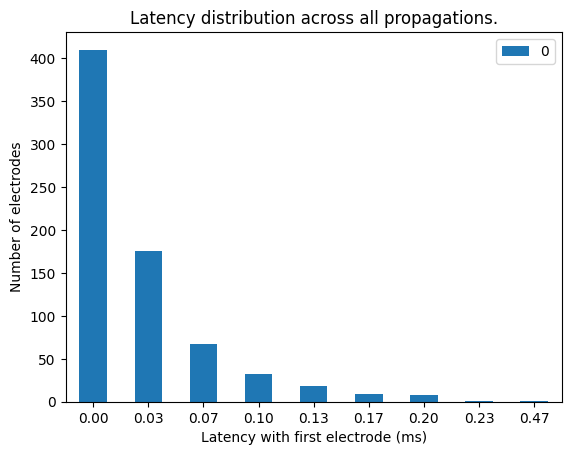

In [ ]:
## Plot histogram of inter-electrode latencies
latencies = []
for prop in propagations:
    latencies.extend(prop.latency.values)
latencies, counts = np.unique(latencies, return_counts=True)
from pandas import DataFrame
df = DataFrame(counts, index=[f"{l:.2f}" for l in latencies])
df.plot.bar(rot=0)
plt.title("Latency distribution across all propagations.")
plt.xlabel("Latency with first electrode (ms)")
plt.ylabel("Number of electrodes")
plt.show()

## Propagations spikes

In [ ]:
PROP_AFTER = 0.5  # Coactivations must occur within PROP_AFTER ms
COACTIVATIONS_N_MIN = 2
COACTIVATIONS_P_MIN = 50
ISI_VIOL = 1.5

propagating_times, propagating_amps = get_propagating_times_and_amps_all()

100%|██████████| 144/144 [00:22<00:00,  6.40it/s]


## Merge propagations

In [ ]:
INCLUDE_MAX_ELEC = True  # Whether to include electrode with max amp (rel amp = 1) in histogram

hist_amps = []
for amps in propagating_amps:
    max_amp = np.max(amps)
    for amp in amps:
        if not INCLUDE_MAX_ELEC and amp == max_amp:
            continue
        hist_amps.append(amp / np.max(amps))
        
plot.hist(hist_amps, xlim=(0, 1), bins=np.arange(0, 1.01, 0.05))

title = "Each point is an electrode"
if not INCLUDE_MAX_ELEC:
    title += ", not including max elec"
plt.title(title)

plt.xlabel("Relative amplitude")
plt.xticks(np.arange(0, 1.001, 0.1))

plt.ylabel("Number of electrodes")
plt.ylim(0, 190)

plt.show()

### Step Merge

In [ ]:
MERGE_METHOD = "average"

# Probably don't change this unless revamping merging process
MERGE_CRITERION = "distance"

merge_scores = get_merge_scores()

In [ ]:
# Distribution of scores of pairs that have at least 2 shared electrodes
seq_order_scores = []
rel_amp_scores = []
for i in range(len(propagations)):
    for j in range(i+1, len(propagations)):
        elec_n, elec_p, seq, rel = get_pair_merge_scores(i, j)
        seq_order_scores.append(seq)
        rel_amp_scores.append(rel)

# Sequence order
plot.hist(seq_order_scores, bins=20)

plt.title("For units with at least 2 shared electrodes")
plt.xlabel("Sequence order similarity score")
plt.xlim(0)
plt.ylabel("Number of pairs")
plt.show()

plot.hist(np.array(seq_order_scores)*recording.get_sampling_frequency(), bins=20)

plt.title("For units with at least 2 shared electrodes")
plt.xlabel("Sequence order similarity score")
plt.xlim(0)
plt.ylabel("Number of pairs")
plt.show()

# Relative amplitude

plot.hist(rel_amp_scores, bins=20)

plt.title("For units with at least 2 shared electrodes")
plt.xlabel("Relative amplitude similarity score")
plt.xlim(0)
plt.ylabel("Number of pairs")
plt.show()

In [ ]:
#### ELECTRODE OVERLAP ####

# Graph distribution of electrode overlap scores
nums = []
scores = []
ind_a, ind_b = np.triu_indices(len(propagations), k=1)
for i_a, i_b in zip(ind_a, ind_b):
    prop_a = propagations[i_a]
    prop_b = propagations[i_b]
    num, score = score_elec_overlap(prop_a, prop_b)
    
    if score > 0:
        scores.append(score)
        nums.append(num)
# Create plot
plt.title("Non-zero electrode overlap % distribution.")
plt.xlabel("% overlapping electrodes")
plot.hist(scores, bins=np.arange(0, 101, 10), labels=True)
plt.ylabel("Num pairs")
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10), [f"{r}%" for r in np.arange(0, 101, 10)])
plt.show()

plt.title("Non-zero electrode overlap num distribution.")
plt.xlabel("Num overlaping electrodes")
plot.hist(nums, bins=max(nums)-1, labels=True)
plt.ylabel("Num pairs")
plt.xlim(1, max(nums))
plt.show()

In [ ]:
ELEC_OVERLAP_N_MIN = 2 # 2
ELEC_OVERLAP_P_MIN = 50
no_merge_ind_elec = (merge_scores[:, 0] < ELEC_OVERLAP_N_MIN) | (merge_scores[:, 1] < ELEC_OVERLAP_P_MIN)

In [ ]:
#### SEQUENCE ORDER ####
SEQ_ORDER_EXTREMUM = 100000  # Value to assign prop pairs that should not be merged
SEQ_ORDER_MAX_VALUES = np.linspace(-0.001, 0.1, num=1000)  # Values to test in plot
##

pdist = merge_scores[:, 2].copy()
pdist[no_merge_ind_elec] = SEQ_ORDER_EXTREMUM

nums_merges = []
means_lens = []
stds_lens = []
for seq_order_max in SEQ_ORDER_MAX_VALUES:
    prop_lens = [len(p) for p in merge(seq_order_max)]
    
    nums_merges.append(len(prop_lens))
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

print(f"Num. propagations: {len(propagations)}")

# Create plot
plt.title("Num. merged propagations based on sequence order overlap.")
plt.xlabel("Sequence order threshold")
plt.ylabel("Num. merged propagations")
plt.scatter(SEQ_ORDER_MAX_VALUES, nums_merges)
plt.xlim(min(SEQ_ORDER_MAX_VALUES), max(SEQ_ORDER_MAX_VALUES))
plt.xticks(np.arange(11)/100)
plt.ylim(30, len(propagations))
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

In [ ]:
plt.hist(merge_scores[:, 3], range=(0, 1), bins=40)
plt.title("Relative amplitude overlap score distribution.")
plt.xlabel("Relative amplitude overlap score")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.show()

In [ ]:
#### RELATIVE AMPLITUDE ####
REL_AMP_EXTREMUM = 100000  # Value to assign prop pairs that should not be merged

REL_AMP_MAX_VALUES = np.linspace(0, 1, num=400)  # Values to test in plot

SEQ_ORDER_MAX_VALUES = [0, 0.03, 0.035, 0.06]
CMAP = plt.cm.get_cmap("viridis", len(SEQ_ORDER_MAX_VALUES))
##
norm = plt.Normalize(SEQ_ORDER_MAX_VALUES[0], SEQ_ORDER_MAX_VALUES[-1])
for seq_order_max in SEQ_ORDER_MAX_VALUES:    
    no_merge_ind_seq = no_merge_ind_elec | (merge_scores[:, 2] > seq_order_max)

    pdist = merge_scores[:, 3].copy()
    pdist[no_merge_ind_seq] = REL_AMP_EXTREMUM

    nums_merges = []
    means_lens = []
    stds_lens = []
    for rel_amp_max in REL_AMP_MAX_VALUES:
        prop_lens = [len(p) for p in merge(rel_amp_max)]
        
        nums_merges.append(len(prop_lens))
        if len(prop_lens) > 0:
            means_lens.append(np.mean(prop_lens))
            stds_lens.append(np.std(prop_lens))
        else:
            means_lens.append(0)
            stds_lens.append(0)
            
    color = CMAP(norm(seq_order_max))
    plt.scatter(REL_AMP_MAX_VALUES, nums_merges, color=color, label=seq_order_max, alpha=0.6)
# print(f"Num. propagations: {len(propagations)}")

# Create plot
plt.title("Num. merged propagations based on relative amplitude overlap.")
plt.xlabel("Relative amplitude threshold")
plt.ylabel("Num. merged propagations")
# plt.scatter(REL_AMP_MAX_VALUES, nums_merges)
plt.xlim(min(REL_AMP_MAX_VALUES), max(REL_AMP_MAX_VALUES))
plt.ylim(60, len(propagations))
plt.legend()
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

### All merge

In [ ]:
ELEC_OVERLAP_N_MIN = 2
ELEC_OVERLAP_P_MIN = 50

SEQ_ORDER_MAX = 0.03

REL_AMP_MAX = 0.2
REL_AMP_EXTREMUM = 10000

MERGE_METHOD = "average"
MERGE_CRITERION = "distance"

merge_scores = get_merge_scores()

Num propagations: 144
Num merged propagations: 89
Mean: 8438.06
STD: 5892.64


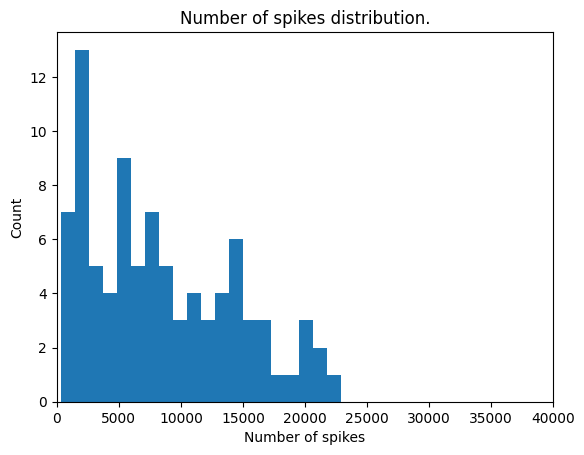

In [ ]:
no_merge_ind_elec = (merge_scores[:, 0] < ELEC_OVERLAP_N_MIN) | (merge_scores[:, 1] < ELEC_OVERLAP_P_MIN)

no_merge_ind_seq = no_merge_ind_elec | (merge_scores[:, 2] > SEQ_ORDER_MAX)

pdist = merge_scores[:, 3].copy()
pdist[no_merge_ind_seq] = REL_AMP_EXTREMUM

propagations_merged, propagating_times_merged = merge(REL_AMP_MAX, return_times=True)
print(f"Num propagations: {len(propagations)}")
print(f"Num merged propagations: {len(propagations_merged)}")

prop_signal = PropSignal((propagations_merged, propagating_times_merged), RECORDING)
prop_signal.plot_nums_spikes(show=False, bins=20)
plt.xlim(0, 40000)
plt.show()

## Split spikes

In [ ]:
# Set mean amps for each unit
NUM_WF = 300  # Num wf to extract for templates
##
def extract_mean_amps(unit_idx):
    unit = prop_signal[unit_idx]
    mean_amps = []  # One dict for each prop in propagation
    for df in unit.df:
        # For accessing data in propagating_times and propagating_amps
        prop_idx = df_to_prop_idx(df)
        
        # Extract mean amplitudes
        n_before = round(PROP_AFTER * RECORDING.get_sampling_frequency())
        n_after = round(PROP_AFTER * RECORDING.get_sampling_frequency())
        templates = np.zeros((RECORDING.get_num_channels(), n_before+1+n_after), dtype=float)
        if NUM_WF is not None and NUM_WF < len(propagating_times[prop_idx]):
            extract_times = np.random.choice(propagating_times[prop_idx], NUM_WF)
        else:
            extract_times = propagating_times[prop_idx]                
        for time in extract_times:
            frame = round(time * RECORDING.get_sampling_frequency())
            templates += RECORDING.get_traces_filt(frame-n_before, frame+n_after+1)
        # elec_to_amp = {elec: mean_amps[i] for i, elec in enumerate(df.ID)}
        mean_amps.append(np.min(templates / NUM_WF, axis=1))
    return unit_idx, mean_amps

prop_units = []
from multiprocessing import Pool
with Pool(processes=12) as pool:
    for unit_idx, mean_amps in tqdm(pool.imap(extract_mean_amps, range(len(prop_signal))), total=len(prop_signal)):
        unit = prop_signal[unit_idx]
        unit.mean_amps = mean_amps
        prop_units.append(unit)

100%|██████████| 89/89 [00:50<00:00,  1.76it/s]


In [138]:
RMS_THRESH = 5  # Threshold for detection

class MultiDetection:
    """Represents a spike detected by multiple units"""
    def __init__(self, time, unit) -> None:
        """
        unit:
            First unit to be added to detection (order does not matter)
        """
        self.times = []
        self.units = []
        
        self.add_time(time)
        self.add_unit(unit)
        
        self.history = []  # after self.split, self.history = [(unit_detecting_spike, sub_amps)]
        """
        After self.split(), self.history will be filled with one element per unit that detected spike
        []
        """        
        
    def __len__(self):
        return len(self.times)
        
    def get_duration(self):
        return self.times[-1] - self.times[0]
        
    def add(self, time, unit):
        self.add_time(time)
        self.add_unit(unit)
        
    def add_time(self, time):
        self.times.append(time)
        
    def add_unit(self, unit):
        self.units.append(unit)
        
    def split(self):             
        """
        Keep track of local copy of {(elec, st): mean subtraction} and apply to loop1
        Loop:
            1. Find which units have enough coactivations to detect spike
                If no units, break loop
            2. Find which unit has largest amplitude
                Assign spike to this unit
        Update units' spike trains
        """
        
        class UnitStruct:
            """Data structure"""
            def __init__(self, unit, merge_idx, time, amp) -> None:
                self.unit = unit
                self.merge_idx = merge_idx
                self.time = time
                self.amp = amp
        
        self.history = []
        
        sub_amps = {}  # {(elec, cross_idx): mean amplitude to subtract from thresh crossing}      
        units_detected = set()  
        while True:
            max_unit = None  # UnitStruct with largest amplitude
                                    
            for time, unit in zip(self.times, self.units):
                if unit in units_detected:
                    continue
                
                for merge_idx, df in enumerate(unit.df):
                    # Count coactivations
                    num_coactivations = 0
                    for elec in df.ID:
                        cross_times = CROSS_TIMES[elec]
                        cross_amps = CROSS_AMPS[elec]
                        cross_idx = np.searchsorted(cross_times, time)
                        # Check if 1) Thresh crossing exists 2) Thresh crossing within PROP_AFTER 3) Thresh crossing >= X*RMS
                        if cross_idx < len(cross_times) and \
                            cross_times[cross_idx] <= time + PROP_AFTER and \
                                cross_amps[cross_idx] - sub_amps.get((elec, cross_idx), 0) >= CHANS_RMS[elec] * RMS_THRESH:
                                    num_coactivations += 1
                        elif elec == df.ID[0]:
                            # If first elec does not detect spike, then sequence does not detect spike (num_coactivations already set to 0)
                            break
                        
                    # Check if seq could have detected spike
                    coactivations_min = max(COACTIVATIONS_N_MIN, COACTIVATIONS_P_MIN/100 * len(df))
                    if num_coactivations >= coactivations_min:
                        time_idx = np.searchsorted(CROSS_TIMES[df.ID[0]], time)
                        amp = CROSS_AMPS[df.ID[0]][time_idx]
                        if max_unit is None or amp > max_unit.amp:
                            max_unit = UnitStruct(unit, merge_idx, time, amp)

            if max_unit is None:
                break
            
            # print(max_unit.unit.df[0].ID[0])
            units_detected.add(max_unit.unit)
            # df = max_unit.unit.df[max_unit.merge_idx]
            
            # Find scaling factor for mean amplitude subtraction
            unit = max_unit.unit
            scale_sub = max_unit.amp / np.abs(unit.mean_amps[max_unit.merge_idx][unit.df[max_unit.merge_idx].ID[0]])
                        
            # Store mean amplitude subtraction
            for elec in range(len(CROSS_TIMES)):
                cross_times = CROSS_TIMES[elec]
                cross_amps = CROSS_AMPS[elec]
                cross_idx = np.searchsorted(cross_times, max_unit.time)
                # Find closest cross time that crosses RMS_THRESH and is within bounds                
                while cross_idx < len(cross_times) and cross_times[cross_idx] <= time + PROP_AFTER and \
                    cross_amps[cross_idx] - sub_amps.get((elec, cross_idx), 0) < CHANS_RMS[elec] * RMS_THRESH:
                        cross_idx += 1
                key, value = (elec, cross_idx), np.abs(max_unit.unit.mean_amps[max_unit.merge_idx][elec]) * scale_sub
                if key not in sub_amps:
                    sub_amps[key] = value
                else:
                    sub_amps[key] += value
            # self.history.append((max_unit.unit, deepcopy(sub_amps)))  # Takes long time to deepcopy

        # assert len(units_detected) == 1, "Test, hopefully error is raised at least once to show spike splitting works"
        
        for time, unit in zip(self.times, self.units):
            if unit not in units_detected:
                idx = np.searchsorted(unit.spike_train, time)
                unit.spike_train = np.delete(unit.spike_train, idx)

        return len(units_detected)

    def plot(self):
        """
        For first spike in self.times, for each unit in self.units, do unit.plot(spike waveform)
        
        no show()
        """
        fig, axes = plt.subplots(1, 2, figsize=(3.6*len(self.units), 4.8))
        
        frame = round(self.times[0] * RECORDING.get_sampling_frequency())
        # wfs = RECORDING.get_traces_filt(frame-10, frame+10+1)
        wfs = RECORDING.get_traces_filt(frame-30, frame+30+1)
        kwargs = self.units[0].plot(subplot=(fig, axes[0]), chans_rms=CHANS_RMS, wf=wfs)
        for i, unit in enumerate(self.units[1:]):
            unit.plot(subplot=(fig, axes[i+1]), wf=wfs, **kwargs)
        return kwargs, wfs, frame-30
        
    def plot_splitting(self):
        """
        Plot process of splitting spike (use after self.split())
        First plot is from self.plot()
        Second plot: each column shows wf after a split on the unit that detected it
        
        The second plot does not change amplitudes of electrodes if there is no thresh crossing (gray)
        """
        
        assert len(self.history) > 0, "Use self.plot_splitting() after self.split()"
        
        print(self.times)
        
        kwargs, wfs, start_frame = self.plot()
        plt.show()
        
        # Create axes
        num_axes = len(self.history)
        fig, axes = plt.subplots(1, num_axes, figsize=(3.6*num_axes, 4.8))
        axes = np.atleast_1d(axes)
        
        # Plot each split
        for h in range(len(self.history)):
            unit = self.history[h][0]
            if h > 0:
                sub_amps = self.history[h-1][1]
                for (elec, cross_idx), amp in sub_amps.items():
                    wf = wfs[elec]
                    # Convert cross_idx to frame in wfs to subtract amp from wfs
                    if cross_idx < len(CROSS_TIMES[elec]):
                        cross_time = CROSS_TIMES[elec][cross_idx]
                        cross_frame = ms_to_frame(cross_time) - start_frame
                        if 0 <= cross_frame < wf.size: 
                            # Account for thresh crossing lasting more than one frame
                            ## Find left side of peak
                            left_idx = cross_frame
                            while left_idx-1 >= 0 and wf[left_idx-1] < 0 and wf[left_idx-1] >= wf[left_idx]:
                                left_idx -= 1
                            ## Find right side of peak
                            right_idx = cross_frame + 1
                            while right_idx < wf.size and wf[right_idx] < 0 and wf[right_idx] >= wf[right_idx-1]:
                                right_idx += 1
                            
                            left_idx = max(left_idx, left_idx-2)  # Add a couple frames of buffer
                            right_idx = min(right_idx, right_idx+2)
                            
                            wf_amp = wf[cross_frame]
                            rel_amps = wf[left_idx:right_idx] / wf_amp
                            wf[left_idx:right_idx] = rel_amps * (wf_amp + amp) 
            unit.plot(subplot=(fig, axes[h]), wf=wfs, **kwargs)
                
        plt.show()        
        
    def get_elecs(self):
        elecs = set()
        for unit in self.units:
            for df in unit.df:
                elecs.update(df.ID)
        return np.array([e for e in elecs])
    
    def __len__(self):
        return len(self.units)     
    
    
def ms_to_frame(ms):
    return round(ms * RECORDING.get_sampling_frequency())
    

class SpikeSplitting:
    def __init__(self, prop_units):
        # self.prop_units = [unit.copy() for unit in prop_units]
        self.prop_units = prop_units

    def run(self):
        # region Only split spikes occurring on same frame
        # multidetections = {}  # {spike_time: MultiDetection}
        # for unit in self.prop_units:
        #     for st in unit.spike_train:
        #         if st not in multidetections:
        #             multidetections[st] = MultiDetection(st, unit)
        #         else:
        #             multidetections[st].add_unit(unit)
                    
        # count = 0
        # for st, multidetection in tqdm(multidetections.items(), total=len(multidetections)):
        #     if len(multidetection) > 1:
        #         # if count > 1:
        #         #     break
                
        #         # print("-"*20)
        #         # unit = multidetection.split()
        #         # if unit is not None:
        #         #     count += 1
                
        #         # multidetection.split()
        #         return multidetection
        # endregion
            
        # Sort spikes
        all_spikes = []
        all_units = []
        for unit in self.prop_units:
            all_spikes.extend(unit.spike_train)
            all_units += [unit] * len(unit.spike_train)
        order = np.argsort(all_spikes)
        all_spikes = np.array(all_spikes)[order]
        all_units = np.array(all_units)[order]
        
        # Form multidetections
        split_overlap = 0.2  # Split spikes that occur within split_overlap
        
        multidetections = [MultiDetection(all_spikes[0], all_units[0])]
        for time, unit in zip(all_spikes[1:], all_units[1:]):
            # if time not in [126705.6, 126705.63333333333]:
            #     continue
            
            # if time < 28790.6 or time > 28790.7:
            #     continue
            
            if time - multidetections[-1].times[-1] <= split_overlap:
                multidetections[-1].add(time, unit)
            else:
                multidetections.append(MultiDetection(time, unit))

        # Split spikes
        # count = -1
        for multi in tqdm(multidetections):
            # count += 1
            # if count != 9:
            #     continue
            
            if len(multi) < 2:
                continue
            
            num_overlaps = multi.split()
            # if num_overlaps > 1:
            #     print("-"*50)
            #     multi.plot_splitting()
                # assert False
                # return multi
                
        return multidetections

        # region Select a specific multidetection
        # durations = [multi.get_duration() for multi in multidetections if len(multi) > 1]
        # order = np.argsort(durations)
        # return multidetections[order[0]]
        # endregion

        # region Sanity check that getting multidetections is working                
        # durations = [multi.get_duration() for multi in multidetections]
        # multi = multidetections[np.argmax(durations)]
        # times = np.array(multi.times)
        # print(multi.get_duration())
        # print(times - times[0])
        # endregion
        
        # region Find longest chain of spikes that need to be split
        # spike_train_all = []
        # for unit in self.prop_units:
        #     spike_train_all.extend(unit.spike_train)
        # spike_train_all = np.sort(spike_train_all)
        # split_time = 0.5  #  Split spikes if within split_time
        # chain_first = spike_train_all[0]
        # cur_chain = 1        
        
        # longest_chain = 0
        # longest_chain_first = 0
        # for i in range(1, len(spike_train_all)):
        #     st2 = spike_train_all[i]
        #     st1 = spike_train_all[i-1]
        #     if st2 - st1 > split_time:
        #         if st1 - chain_first > longest_chain:  # longest_chain = max(longest_chain, cur_chain)
        #             longest_chain = st1 - chain_first
        #             longest_chain_first = chain_first
                    
        #         cur_chain = 1
        #         chain_first = st2
        #     else:
        #         cur_chain += 1
        # longest_chain = max(longest_chain, cur_chain)
        # print(longest_chain)
        # left = np.searchsorted(spike_train_all, longest_chain_first)
        # right = np.searchsorted(spike_train_all, longest_chain_first+longest_chain, side="right")
        # print(spike_train_all[left:right] - longest_chain_first)
        # print(right-left)
        # endregion

    @staticmethod
    def summarize(unit1, unit2, delta=0.4):
        """
        Summarize overlap between two units' spike trains
        """
        times1 = unit1.spike_train
        times2 = unit2.spike_train
        
        idx1 = unit1.idx
        idx2 = unit2.idx
        
        same_frames = Comparison.count_same_frames(times1, times2)
        overlaps = Comparison.count_matching_events(times1, times2, delta)
        print(f"""#spikes:
Same frame: {same_frames}
Overlaps: {overlaps}
Unit {idx1}: {len(times1)}
Unit {idx2}: {len(times2)}""")
                
# IND = [70, 68]
# IND = [0, 1]
##
IND = range(len(prop_units))

prop_units_copy = []
for idx in IND:
    unit = prop_units[idx].copy()
    unit.mean_amps = prop_units[idx].mean_amps
    prop_units_copy.append(unit)

# SpikeSplitting.summarize(*prop_units_copy)

splitting = SpikeSplitting(
    prop_units_copy,
    # [prop_signal[idx] for idx in range(len(prop_signal))],
)
multidetections = splitting.run()

# for multi in multidetections:
#     if len(multi.history) > 1:
#         print("-"*50)
#         multi.plot_splitting()

# print(multi.split())
# multi.plot_splitting()

# SpikeSplitting.summarize(*prop_units_copy)

100%|██████████| 345296/345296 [10:33<00:00, 544.75it/s]


In [ ]:
# for idx in [0, 1]:
#     prop_signal[idx].plot(chans_rms=CHANS_RMS)
#     plt.show()

Mean: 4591.33
STD: 4362.57


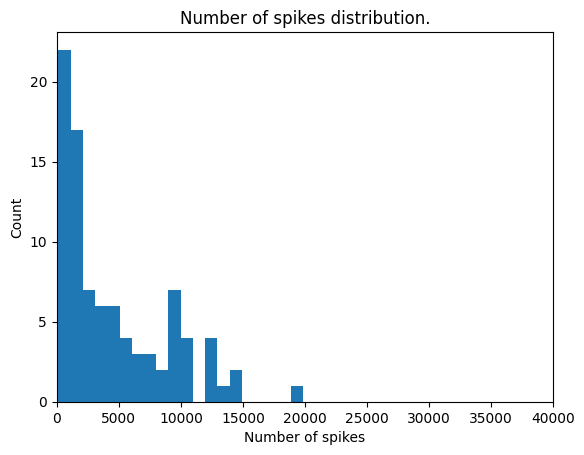

In [139]:
dfs = []
times = []
for unit in splitting.prop_units:
    dfs.append(unit.df)
    times.append(unit.spike_train)
prop_signal = PropSignal((dfs, times), RECORDING, "Prop max amp splitting")
prop_signal.plot_nums_spikes(show=False, bins=20)
plt.xlim(0, 40000)
plt.show()

## Save prop signal

In [151]:
# prop_signal.save("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230824", "Max amp elec spike splitting with scaling to match individual spikes")

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [8]:
prop_signal = PropSignal("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230718", RECORDING)

Mean: 8186.02
STD: 5434.61


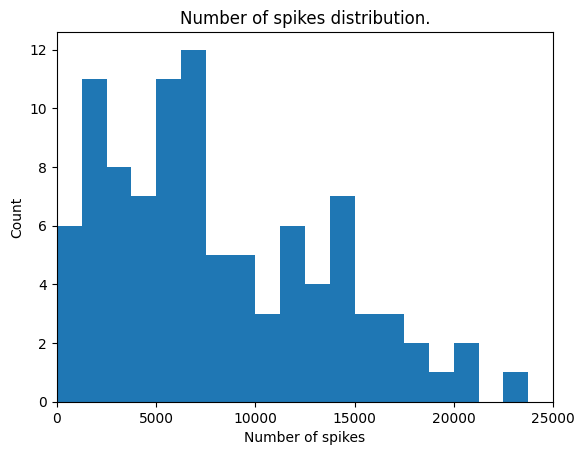

In [11]:
prop_signal.plot_nums_spikes(show=False, bins=20, range=(0, 25000))
plt.xlim(0, 25000)
plt.show()

## Plot propagations

In [ ]:
for idx in range(0, len(prop_signal), 1):
    prop_signal[idx].plot()

## Examine spike splittng problem

100%|██████████| 89/89 [00:01<00:00, 44.75it/s]


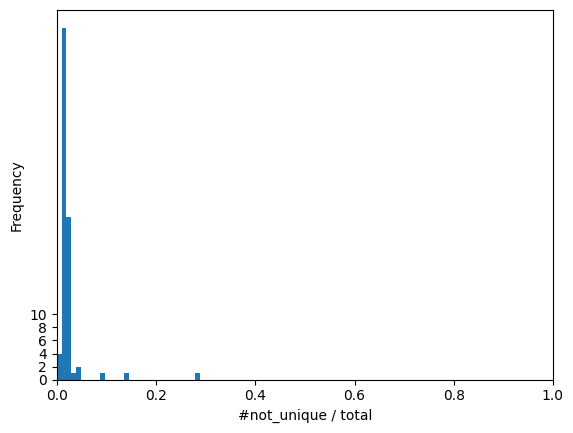

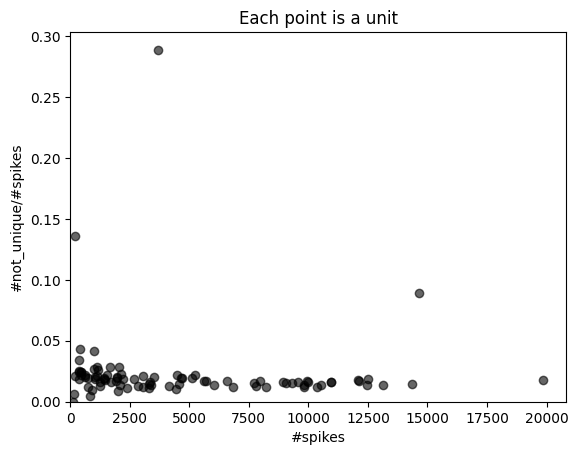

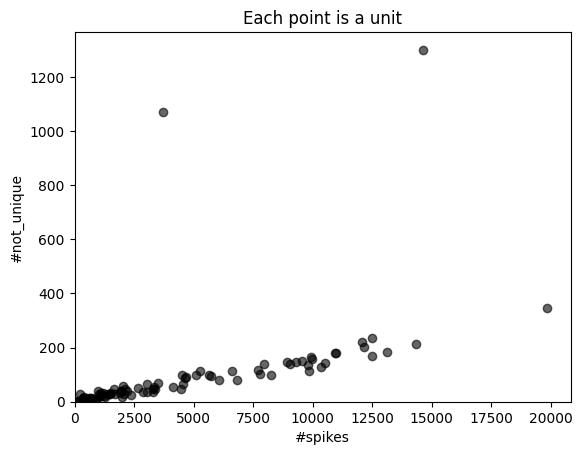

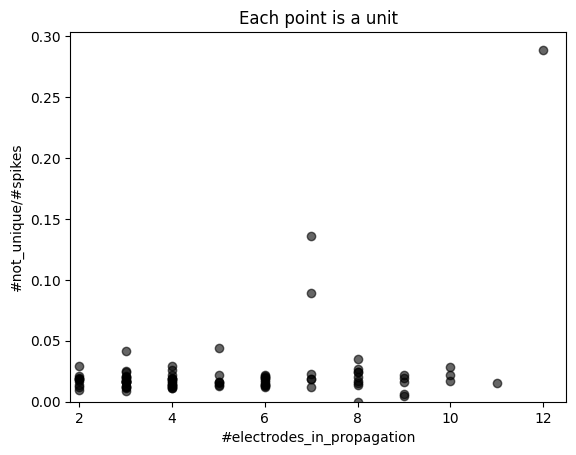

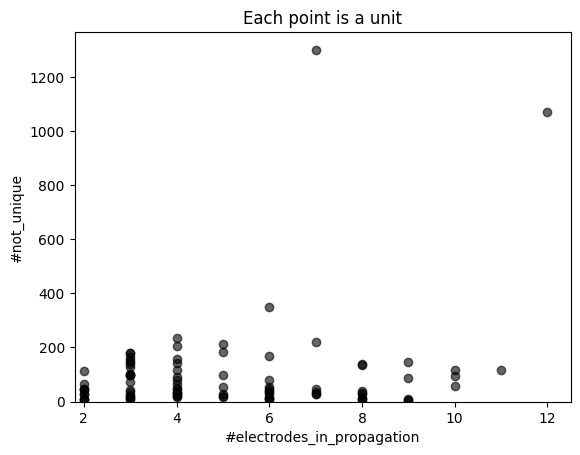

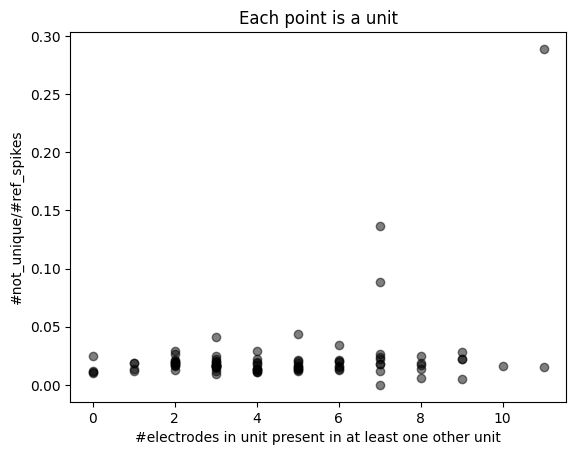

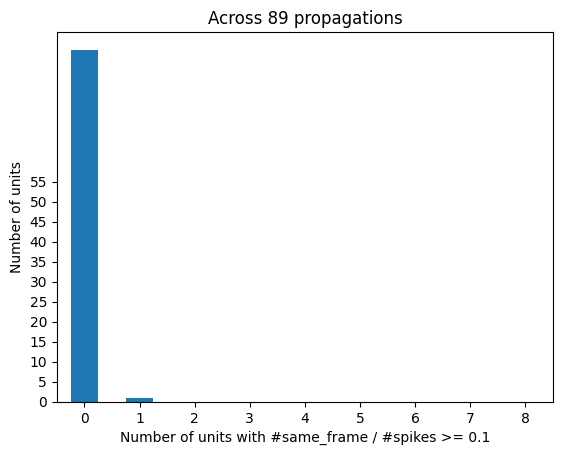

In [140]:
spike_train_sets = []
spike_trains = prop_signal.get_spike_times()
for train in spike_trains:
    spike_train_sets.append(set(train))

overlap_ratios = []  # ith value = #not_unique/#total for spikes of ith propagation
overlap_matrix = np.zeros((len(prop_signal), len(prop_signal)), dtype=float)  # [i, j] = num overlaps between units i and j / num spikes i
for i in tqdm(range(len(prop_signal))):
    unique = spike_train_sets[i]
    for j in range(len(prop_signal)):
        if i == j:
            continue
        overlap_matrix[i, j] = len(spike_train_sets[i].intersection(spike_train_sets[j])) / len(spike_train_sets[i])
        unique = unique.difference(spike_train_sets[j])
    overlap_ratios.append(
        (len(spike_train_sets[i]) - len(unique)) / (len(spike_train_sets[i]))
    )
    
plt.hist(overlap_ratios, bins=30)
plt.yticks(range(0, 12, 2))

plt.ylabel("Frequency")
plt.xlabel("#not_unique / total")
plt.xlim(0, 1)
plt.show()

for i in range(len(prop_signal)):
    plt.scatter(len(prop_signal[i]), overlap_ratios[i], color="black", alpha=0.6)
plt.xlim(0)
plt.ylim(0)
plt.title("Each point is a unit")
plt.ylabel("#not_unique/#spikes")
plt.xlabel("#spikes")
plt.show()

for i in range(len(prop_signal)):
    plt.scatter(len(prop_signal[i]), overlap_ratios[i]*len(prop_signal[i]), color="black", alpha=0.6)
plt.xlim(0)
plt.ylim(0)
plt.title("Each point is a unit")
plt.ylabel("#not_unique")
plt.xlabel("#spikes")
plt.show()
for i in range(len(prop_signal)):
    plt.scatter(len(prop_signal[i].chans), overlap_ratios[i], color="black", alpha=0.6)
plt.xlim(1.8)
plt.ylim(0)
plt.title("Each point is a unit")
plt.ylabel("#not_unique/#spikes")
plt.xlabel("#electrodes_in_propagation")
plt.show()
for i in range(len(prop_signal)):
    plt.scatter(len(prop_signal[i].chans), overlap_ratios[i]*len(prop_signal[i]), color="black", alpha=0.6)
plt.xlim(1.8)
plt.ylim(0)
plt.title("Each point is a unit")
plt.ylabel("#not_unique")
plt.xlabel("#electrodes_in_propagation")
plt.show()
prop_elecs = []

for i in range(len(prop_signal)):
    elecs = set()
    for df in prop_signal[i].df:
        elecs.update(df.ID)
    prop_elecs.append(elecs)

for i in range(len(prop_signal)):
    elecs = prop_elecs[i]
    num_elecs = len(elecs)
    for j in range(len(prop_signal)):
        if i == j:
            continue
        elecs = elecs.difference(prop_elecs[j])
    
    plt.scatter(num_elecs - len(elecs), overlap_ratios[i], color="black", alpha=0.5)

plt.title("Each point is a unit")
plt.xlabel("#electrodes in unit present in at least one other unit")
plt.ylabel("#not_unique/#ref_spikes")
plt.show()
from pandas import DataFrame

OVERLAP_MIN = 0.1  # If two units have #not_unique/#spikes >= OVERLAP_MIN, then they overlap
MAX_BAR = 8  # Bar plot will go up to this 

##
counts = []
for i in range(len(prop_signal)):
    counts.append(np.sum(overlap_matrix[i, :] >= OVERLAP_MIN))
bars, bar_counts = np.unique(counts, return_counts=True)

bar_counts = bar_counts.tolist() + [0] * (MAX_BAR - bars[-1])
bars = bars.tolist() + list(range(bars[-1]+1, MAX_BAR+1))

df = DataFrame(data=bar_counts, index=bars)
df.plot.bar(rot=0, legend=False)

plt.title(f"Across {len(prop_signal)} propagations")
plt.xlabel(f"Number of units with #same_frame / #spikes >= {OVERLAP_MIN}")
plt.ylabel("Number of units")
# plt.yticks(range(0, 33, 4))
plt.yticks(range(0, 60, 5))

plt.show()


In [ ]:
# plot_sharing_props(70, chans_rms=CHANS_RMS)

In [ ]:
# Select specific units to examine
UNIT_IND = np.argsort(overlap_ratios)[:10]
print(UNIT_IND)
print(np.array(overlap_ratios)[UNIT_IND])

In [ ]:
# for i in range(len(prop_signal)):
TOP_N = 3 
for i in UNIT_IND:
    # Get prop
    prop = prop_signal[i]
    ref_id = prop.elec_id
    
    # Plot scatter
    plt.title(f"Elec ID: {ref_id}")
    plt.axvline(ref_id, color="black", linestyle="dashed", alpha=0.7)
    for j in range(len(prop_signal)):
        if i == j:
            continue
        plt.scatter(prop_signal.props[j][0].ID[0], overlap_matrix[i, j])
    plt.show()
    
    # Plot prop
    kwargs = prop.plot(chans_rms=chans_rms, return_kwargs=True)
    
    # Plot top TOP_N props with highest overlap
    for j in np.argsort(overlap_matrix[i, :])[-TOP_N:]:
        comp_prop = prop_signal[j]
        comp_prop.plot(**kwargs)

### Individual spikes

In [ ]:
MAX_PLOTS = 50
np.random.seed(241)
##
UNIT1 = splitting.prop_units[0]  # prop_signal[70]
UNIT2 = splitting.prop_units[1]  # UNIT2 = prop_signal[68]

same_spikes = np.intersect1d(UNIT1.spike_train, UNIT2.spike_train)

for st in np.random.choice(same_spikes, size=MAX_PLOTS):
    frame = round(st * RECORDING.get_sampling_frequency())
    wf = RECORDING.get_traces_filt(frame-60, frame+61)
    if np.argmin(np.min(wf, axis=1)) != UNIT2.df[0].ID[0]:
        continue
    
    print(st)
        
    kwargs = UNIT1.plot(chans_rms=CHANS_RMS, wf=wf, return_kwargs=True)
    wf[UNIT2.df[0].ID, 56:65] = 0
    UNIT1.plot(wf=wf, **kwargs)

In [ ]:
for w in wf:
    plt.scatter(np.arange(w.size), w)
    plt.plot(w)
plt.show()

## Comparison with Kilosort2

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/data/MEAprojects/PropSignal/src/comparison.py:335: UserWarning: Using Comparison.count_matching_events_si which may be inaccurate
  warnings.warn("Using Comparison.count_matching_events_si which may be inaccurate", UserWarning)
/data/MEAprojects/PropSignal/src/sorters/kilosort.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

Recording does not have scaled traces. Setting gain to 0.195
Mean: 5149.54
STD: 5190.28


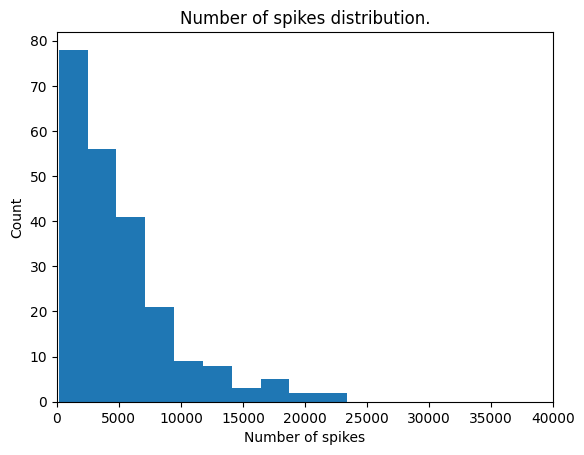

In [75]:
# Load kilosort
# kilosort = Kilosort(utils.PATH_SM4_SI, "first", RECORDING)
from src.sorters.kilosort import get_experts_kilosort
kilosort = get_experts_kilosort()
kilosort.plot_nums_spikes(show=False, bins=20)
plt.xlim(0, 40000)
plt.show()

In [ ]:
max_chans = []
for i in range(len(kilosort)):
    ks = kilosort[i]
    template = ks.get_template_mean()
    chan = np.argmin(np.min(template, axis=1))
    max_chans.append(chan)
chans, counts = np.unique(max_chans, return_counts=True)

plot.bar(counts, xmax=12)

plt.title(f"{len(kilosort)} units. {kilosort.recording.get_num_channels()} elecs. Max elecs.")
plt.xlabel(f"Number of units detected on the same electrode")
plt.ylabel("Number of electrodes")
plt.ylim(0, 70)
plt.show()

In [ ]:
RMS_THRESH = 2.5

chans = []
for unit in kilosort:    
    templates = unit.get_template_mean()
    
    amps = np.min(templates, axis=1)
    elec_mask = amps < -RMS_THRESH * chans_rms
    elecs = np.flatnonzero(elec_mask)
    if elecs.size == 0:
        elecs = [np.argmin(amps)]
    
    latencies = np.argmin(templates, axis=1)
    min_latency = np.min(np.argmin(templates[elecs], axis=1))
    chan = None
    min_amp = np.inf
    for elec in elecs:
        if latencies[elec] == min_latency and amps[elec] < min_amp:
            chan = elec
            min_amp = amps[elec]
    chans.append(chan)
    
_, counts = np.unique(chans, return_counts=True)

plot.bar(counts, xmax=8)

plt.title(f"{len(kilosort)} units. {kilosort.recording.get_num_channels()} elecs. First elecs, {RMS_THRESH}RMS.")

plt.xlabel("Number of units detected on the same electrode")

plt.ylabel("Number of electrodes")
plt.ylim(0, 70)

plt.show()


In [56]:
# Num unique spikes
def count_unique_and_total_spikes(sorter):
    spikes_unique = set()
    total = 0
    for spikes in sorter.get_spike_times():
        spikes_unique.update(spikes)
        total += len(spikes)
    
    # return spikes_unique, spikes_total
    unique = len(spikes_unique)
    
    print(f"Unique/Total: {unique}/{total} = {unique/total*100:.1f}%")

print("Kilosort:")
count_unique_and_total_spikes(kilosort)
print()
print("Prop:")
count_unique_and_total_spikes(prop_signal)

Kilosort:
Unique/Total: 1187625/1223360 = 97.1%

Prop:
Unique/Total: 404258/408628 = 98.9%


In [ ]:
# If ks spike not removed from ks_spikes after assigned to a prop spike, i.e. more than one spike from different prop units assigned to one ks unit

ks_spikes = set()
for unit in kilosort:
    ks_spikes.update(unit.spike_train)
ks_spikes = np.sort(list(ks_spikes))

prop_ks_spikes = []
prop_dataframes = []
total_matching = 0
for unit in tqdm(prop_signal):
    matching_spikes, unmatched_prop, unmatched_ks = Comparison.get_matching_events(unit.spike_train, ks_spikes)
    total_matching += len(matching_spikes)
    prop_ks_spikes.append(np.sort(matching_spikes))
    prop_dataframes.append(unit.df)
total_matching/sum(len(unit.spike_train) for unit in prop_signal) * 100

In [ ]:
# One kilosort spike to at most one prop unit

ks_spikes = set()
for unit in kilosort:
    ks_spikes.update(unit.spike_train)
ks_spikes = np.sort(list(ks_spikes))

prop_ks_spikes = []
prop_dataframes = []
total_matching = 0
for unit in tqdm(prop_signal):
    matching_spikes, unmatched_prop, unmatched_ks = Comparison.get_matching_events(ks_spikes, unit.spike_train)
    total_matching += len(matching_spikes)
    prop_ks_spikes.append(np.sort(matching_spikes))
    prop_dataframes.append(unit.df)
    
    ks_spikes = np.setdiff1d(ks_spikes, matching_spikes)
    
total_matching/sum(len(unit.spike_train) for unit in prop_signal) * 100

In [ ]:
prop_signal_ks = PropSignal([prop_dataframes, prop_ks_spikes], RECORDING)

In [ ]:
comp_1_5 = Comparison(prop_signal_ks, kilosort, score_formula=1.5)
comp_1_5.summary()

comp_1 = Comparison(prop_signal_ks, kilosort, score_formula=1)
comp_1.summary()

comp_2 = Comparison(prop_signal_ks, kilosort, score_formula=2)
comp_2.summary()

Num Prop.: 89
Num Kilosort2: 339
Num single matches: 21

For Prop.:
Num max matches: 21
Num unique max matches: 21

For Kilosort2:
Num max matches: 24
Num unique max matches: 21


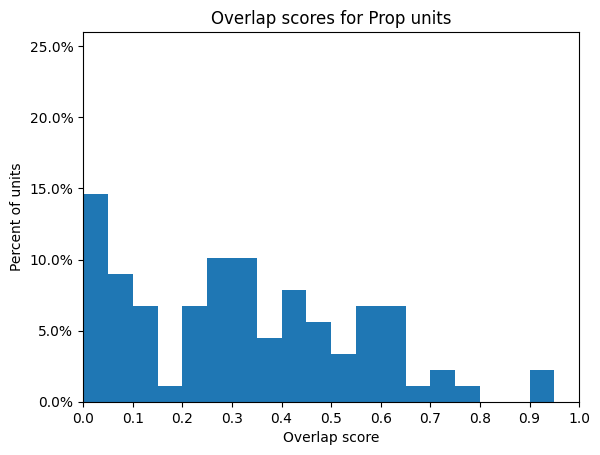

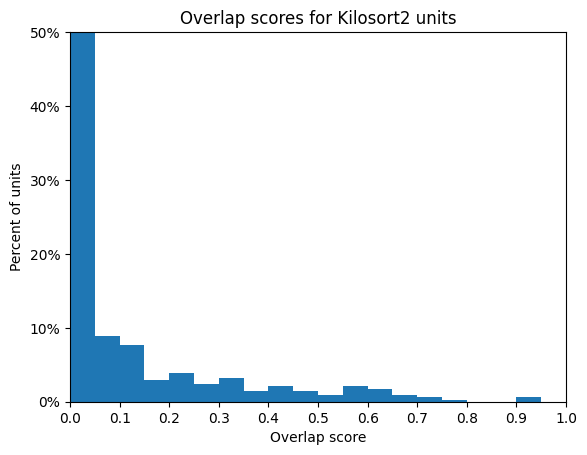

Num Prop.: 89
Num Kilosort2: 339
Num single matches: 47

For Prop.:
Num max matches: 56
Num unique max matches: 47

For Kilosort2:
Num max matches: 51
Num unique max matches: 47


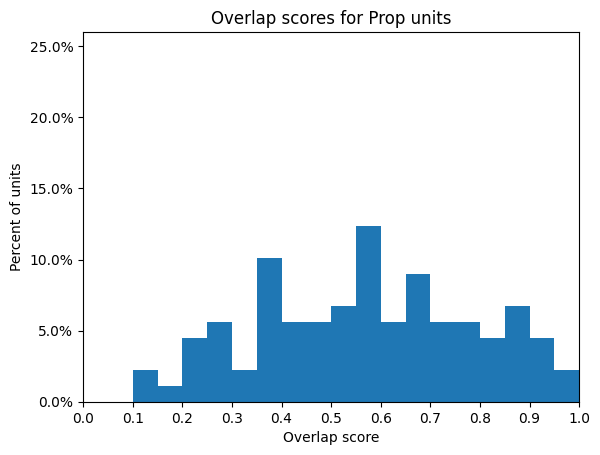

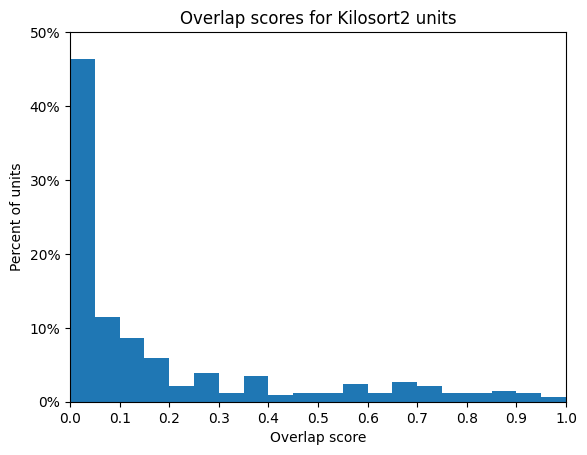

Num Prop.: 89
Num Kilosort2: 339
Num single matches: 49

For Prop.:
Num max matches: 49
Num unique max matches: 48

For Kilosort2:
Num max matches: 103
Num unique max matches: 48


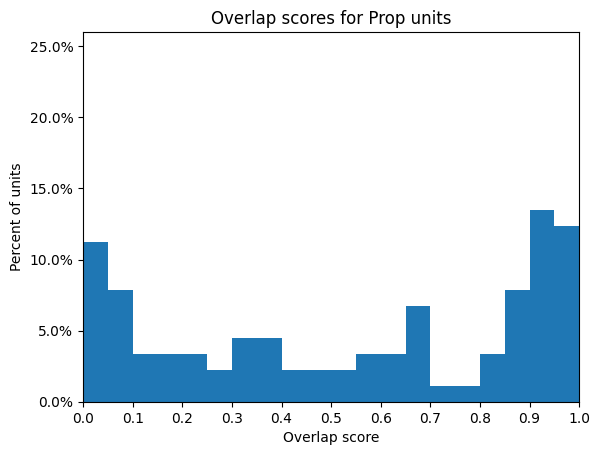

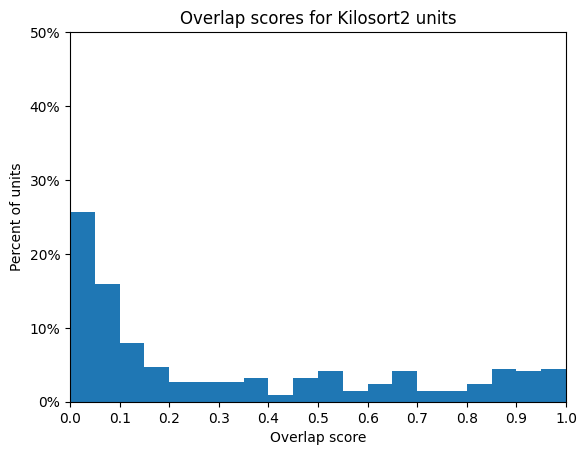

In [57]:
# plot.set_dpi(300)

comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5)
comp_1_5.summary()

comp_1 = Comparison(prop_signal, kilosort, score_formula=1)
comp_1.summary()

comp_2 = Comparison(prop_signal, kilosort, score_formula=2)
comp_2.summary()

In [58]:
prop_train = set()
for unit in prop_signal:
    prop_train.update(unit.spike_train)
prop_train = np.sort(list(prop_train))
    
ks_train = set()
for unit in kilosort:
    ks_train.update(unit.spike_train)
ks_train = np.sort(list(ks_train))

num_matches = Comparison.count_matching_events(prop_train, ks_train,
                                               delta=0.4)
print(f"#spikes:")
print(f"Matches: {num_matches}")
print(f"Prop: {len(prop_train)}, {num_matches/len(prop_train)*100:.1f}")
print(f"Kilosort: {len(ks_train)}, {num_matches/len(ks_train)*100:.1f}")

#spikes:
Matches: 392060
Prop: 404258, 97.0
Kilosort: 1187625, 33.0


In [147]:
len(prop_signal)

89

### Line comparison

Change Prop to Prop + DL if necessay


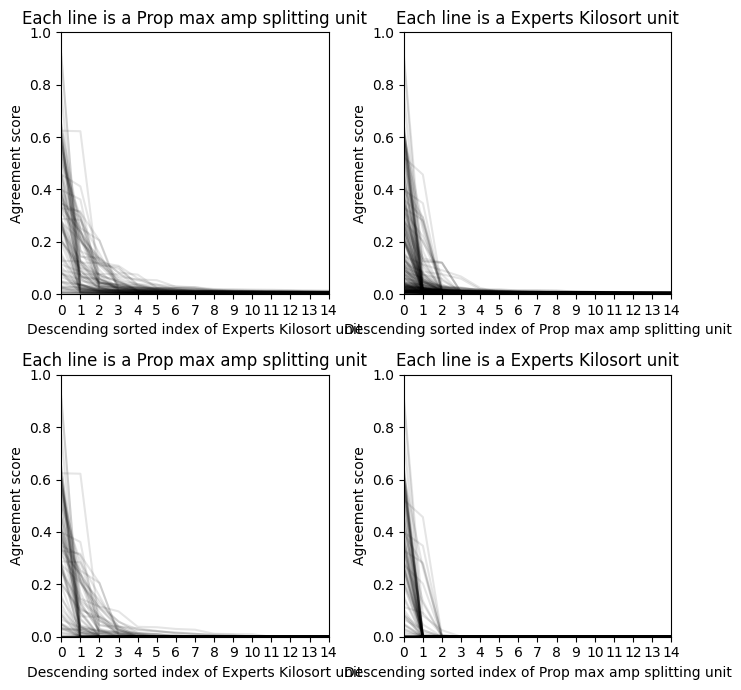

Change Prop to Prop + DL if necessay


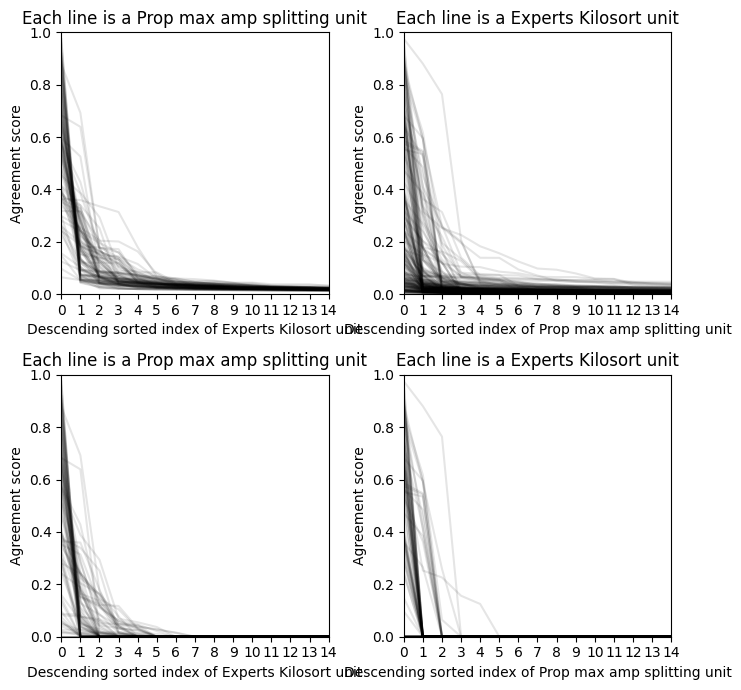

Change Prop to Prop + DL if necessay


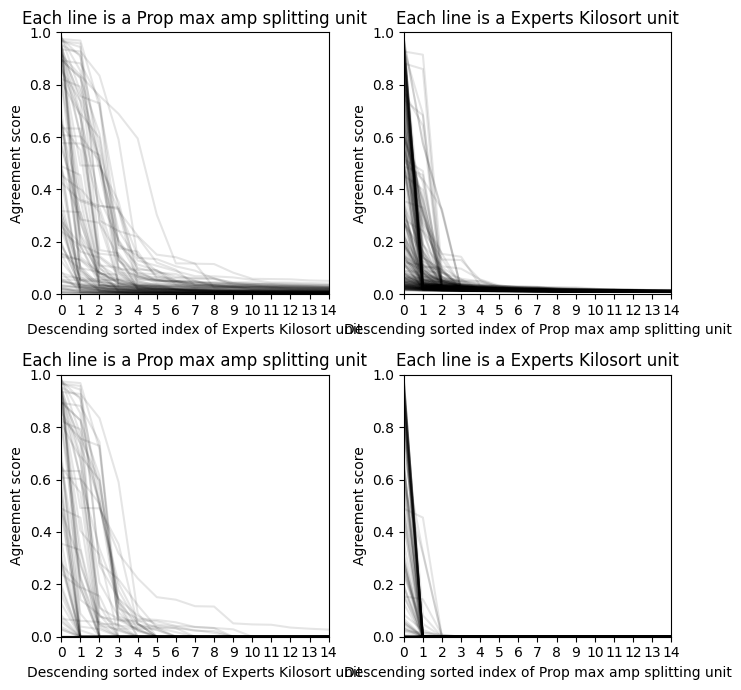

In [150]:
comp_1_5.plot_line_comps()
comp_1.plot_line_comps()
comp_2.plot_line_comps()

In [ ]:
ks_matches_ind = np.argsort([len(ks) for ks in matches])
ks_idx = ks_matches_ind[-1]
ks_most = matches[ks_idx]
ks = kilosort[ks_idx]
print(ks_idx, len(ks))
print(len(ks_most))

In [ ]:
for prop_idx in ks_most:
    prop = comp_2.sorter1[prop_idx]
    print(prop_idx, len(prop))
    print(ks_idx, len(ks), comp_2.count_matching_events(ks.spike_train, prop.spike_train) / ks.spike_train.size)
    
    # Find matching kilosort unit
    for pid, kid in comp_2.matching_uids:
        if pid == prop_idx:
            ks_max = kilosort[kid]
            print(kid, len(ks_max), comp_2.count_matching_events(ks_max.spike_train, prop.spike_train) / ks_max.spike_train.size)
            break
    else:
        print(None)
    
    prop.plot()

In [ ]:
ks_idx = ks_matches_ind[-3]
ks_most = matches[ks_idx]
ks = kilosort[ks_idx]
print(ks_idx, len(ks))
print(len(ks_most))

In [ ]:
for prop_idx in ks_most:
    prop = comp_2.sorter1[prop_idx]
    print(prop_idx, len(prop))
    print(ks_idx, len(ks), comp_2.count_matching_events(ks.spike_train, prop.spike_train) / ks.spike_train.size)
    
    # Find matching kilosort unit
    for pid, kid in comp_2.matching_uids:
        if pid == prop_idx:
            ks_max = kilosort[kid]
            print(kid, len(ks_max), comp_2.count_matching_events(ks_max.spike_train, prop.spike_train) / ks_max.spike_train.size)
            break
    else:
        print(None)
    
    prop.plot()

In [ ]:
ks_idx = ks_matches_ind[-4]
ks_most = matches[ks_idx]
ks = kilosort[ks_idx]
print(ks_idx, len(ks))
print(len(ks_most))

In [ ]:
for prop_idx in ks_most:
    prop = comp_2.sorter1[prop_idx]
    print(prop_idx, len(prop))
    print(ks_idx, len(ks), comp_2.count_matching_events(ks.spike_train, prop.spike_train) / ks.spike_train.size)
    
    # Find matching kilosort unit
    for pid, kid in comp_2.matching_uids:
        if pid == prop_idx:
            ks_max = kilosort[kid]
            print(kid, len(ks_max), comp_2.count_matching_events(ks_max.spike_train, prop.spike_train) / ks_max.spike_train.size)
            break
    else:
        print(None)
    
    prop.plot()

### Heat map
Could you please make a heatmap figure with a 2D grid of threshold values. For each combination of threshold values, could you see how many prop units that don't have the highest overlap score with kilosort still have an overlap score of at least 0.5? That could help give us more insight in the effect of these two thresholds on the number of potentially undermerged units prop units.

In [ ]:
# Get values for heatmap
SEQ_ORDER_MAX_VALUES = [-0.1, 0, 0.5, 1, 2, 4]
REL_AMP_MAX_VALUES = [0, 0.05, 0.1, 0.2, 0.4, 0.6]

MATCH_SCORE = 0.5  # Minimum agreement score to be considered a match
##
matches_matrix = np.zeros((len(SEQ_ORDER_MAX_VALUES), len(REL_AMP_MAX_VALUES)), dtype=int)
for s, seq_order_max in tqdm(enumerate(SEQ_ORDER_MAX_VALUES), total=len(SEQ_ORDER_MAX_VALUES)):
    for r, rel_amp_max in enumerate(REL_AMP_MAX_VALUES):
        no_merge_ind_seq = no_merge_ind_elec | (merge_scores[:, 2] > seq_order_max)
        pdist = merge_scores[:, 3].copy()
        pdist[no_merge_ind_seq] = REL_AMP_EXTREMUM
        props_m, times_m = merge(rel_amp_max, return_times=True)
        prop_signal = PropSignal([props_m, times_m], recording)
        
        comp = Comparison(prop_signal, kilosort, score_formula=2, match_score=MATCH_SCORE)
        num_matches = 0
        for k in range(len(comp.match21)):
            num_matches += np.sum(comp.agreement_scores[:, k] >= MATCH_SCORE)
            if comp.match21[k] != -1:  # Kilosort unit has a match (i.e. a prop unit with >=MATCH_SCORE)
                num_matches -= 1
        matches_matrix[s, r] = num_matches

In [ ]:
# Create heatmap
TEXT_COLOR = "black"
##
fig, ax = plt.subplots()
heatmap = ax.imshow(matches_matrix, cmap="YlOrRd", origin="lower")

# Set axis labels
ax.set_xlabel("Relative amplitude max")
ax.set_xticks(range(len(REL_AMP_MAX_VALUES)))
ax.set_xticklabels(REL_AMP_MAX_VALUES)

ax.set_ylabel("Sequence order max")
ax.set_yticks(range(len(SEQ_ORDER_MAX_VALUES)))
ax.set_yticklabels(SEQ_ORDER_MAX_VALUES)

# Show the colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label("Number of extra matches")

# Annotate the cells with the condition count
for s in range(matches_matrix.shape[0]):
    for r in range(matches_matrix.shape[1]):
        num_matches = matches_matrix[s, r]
        ax.text(r, s, num_matches, ha="center", va="center", color=TEXT_COLOR)

# Set title
ax.set_title("Prop units matching to the same kilosort unit.")

# Show the plot
plt.show()

## Additional comparison with Kilosort2
Merging kilosort units

In [76]:
comp_2 = Comparison(prop_signal, kilosort, score_formula=2)
# comp_2.summary()

In [61]:
from src.sorters.base import Unit
from multiprocessing import Pool
from pandas import DataFrame

In [77]:
NUM_WFS = 300
MS_BEFORE = 2
MS_AFTER = 2

np.random.seed(231)
##
all_ks_units = [unit for unit in kilosort]
def extract_templates(unit_idx):
    unit = all_ks_units[unit_idx]
    return unit_idx, unit.get_templates(num_wfs=NUM_WFS, ms_before=MS_BEFORE, ms_after=MS_AFTER)

with Pool(processes=12) as pool:
    for unit_idx, templates in tqdm(pool.imap(extract_templates, range(len(all_ks_units))), total=len(all_ks_units)):
        all_ks_units[unit_idx].templates = templates

100%|██████████| 226/226 [01:17<00:00,  2.93it/s]


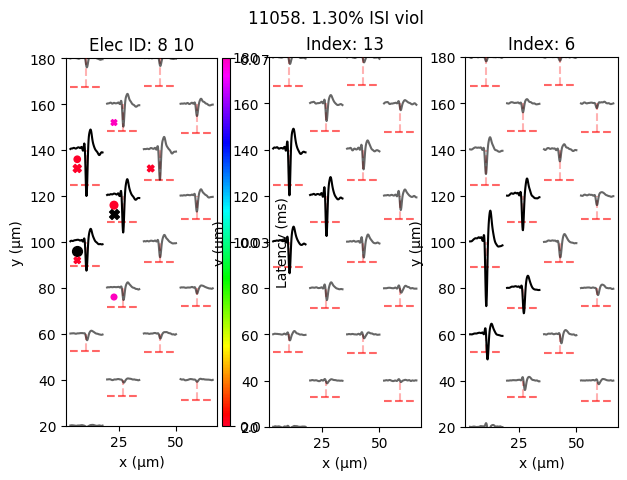

,13,6
13,-1,191
6,-1,-1


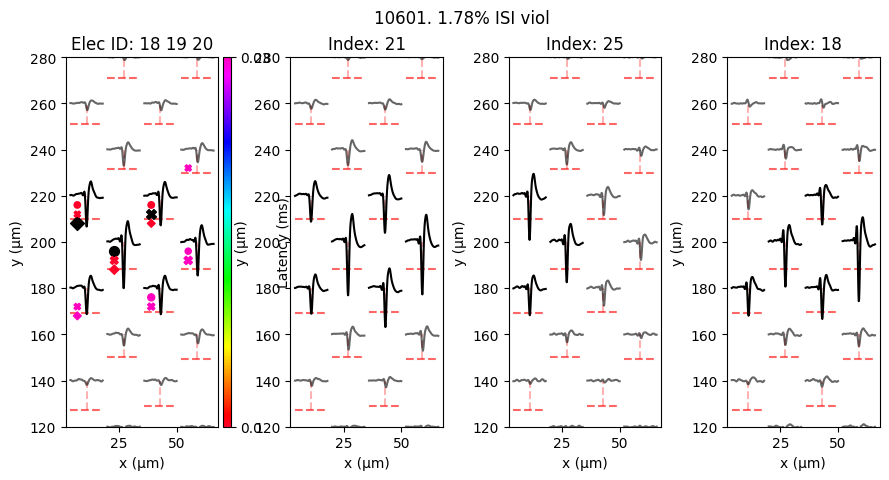

,21,25,18
21,-1,175,176
25,-1,-1,178
18,-1,-1,-1


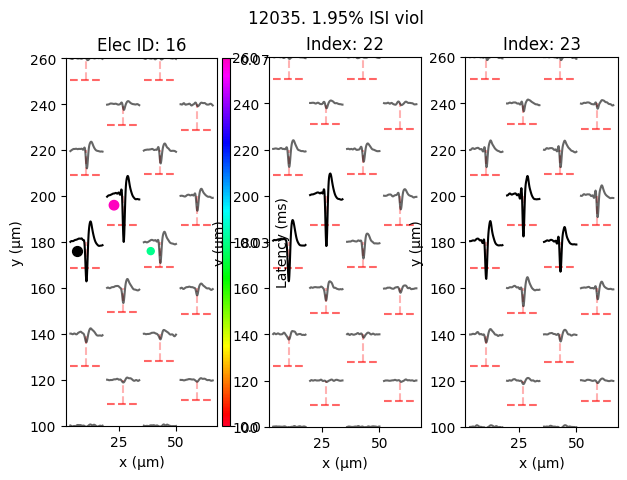

,22,23
22,-1,186
23,-1,-1


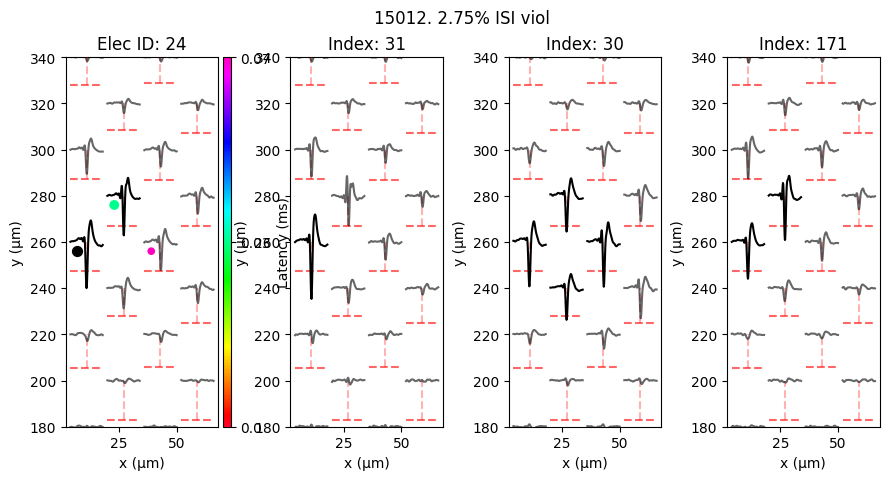

,31,30,171
31,-1,239,202
30,-1,-1,250
171,-1,-1,-1


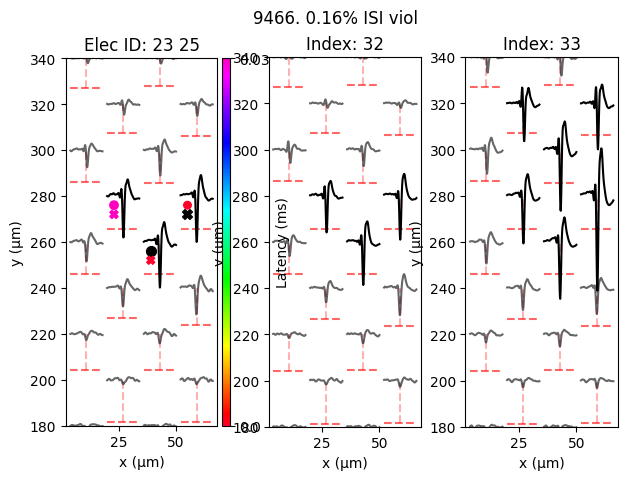

,32,33
32,-1,210
33,-1,-1


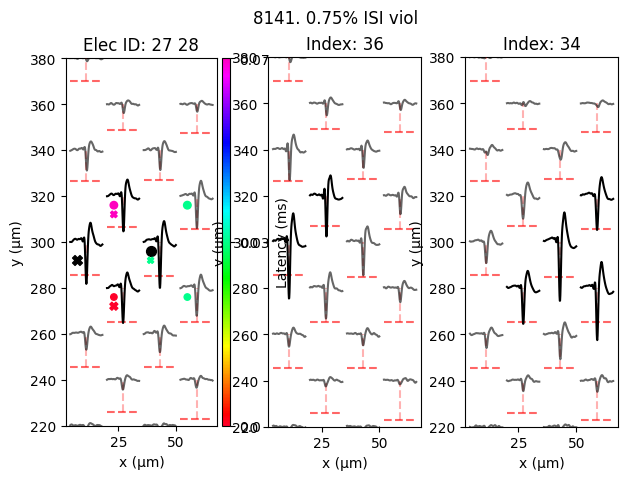

,36,34
36,-1,234
34,-1,-1


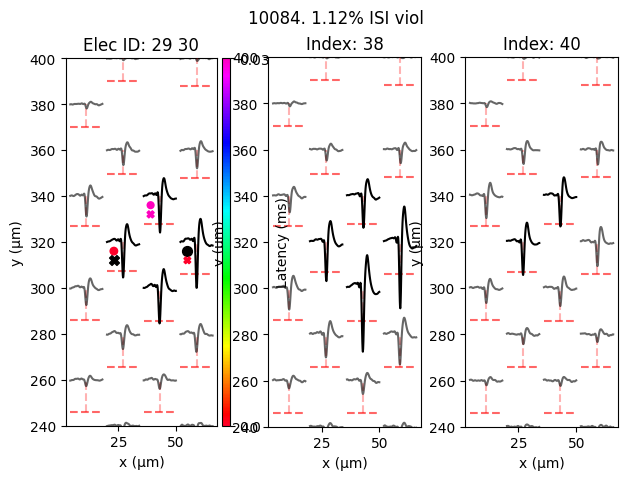

,38,40
38,-1,280
40,-1,-1


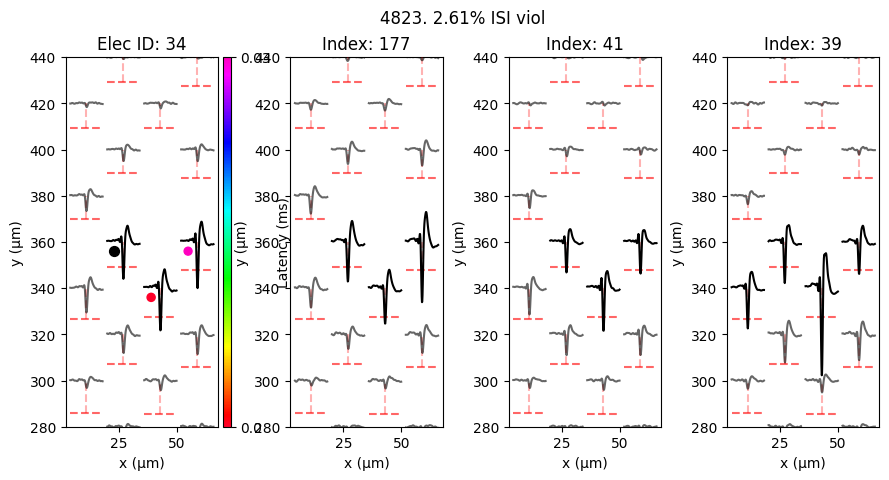

,177,41,39
177,-1,241,184
41,-1,-1,206
39,-1,-1,-1


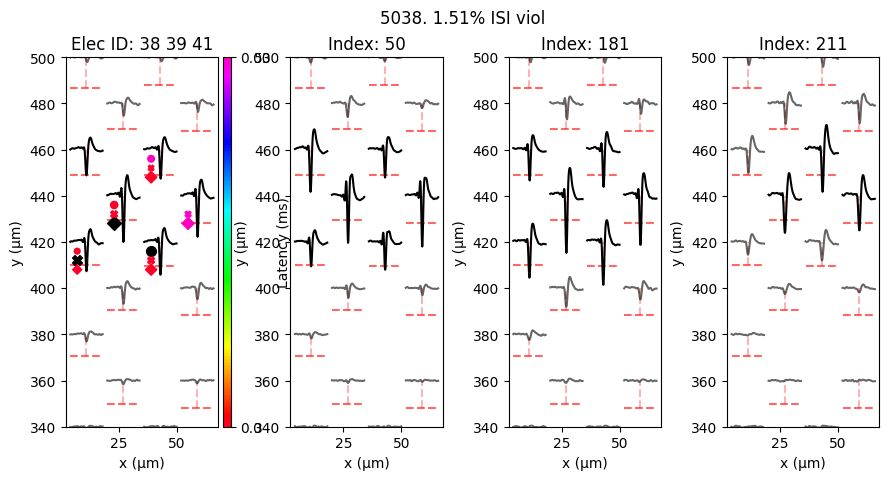

,50,181,211
50,-1,229,285
181,-1,-1,280
211,-1,-1,-1


KeyboardInterrupt: 

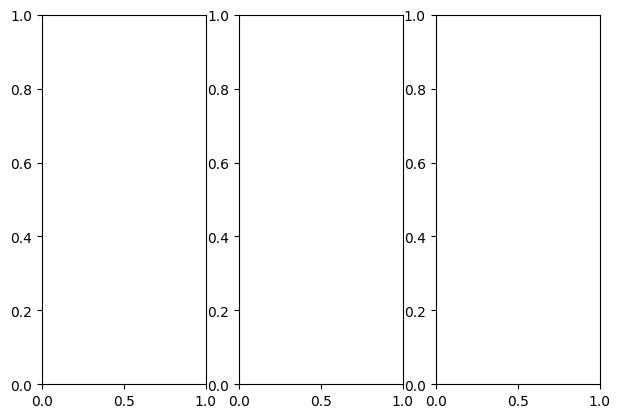

In [81]:
"""
Merge kilosort units

1. Initially merge units if overlap score with same prop unit >= 0.5
    a. Store unmerged units
    b. Store which units could be merged
2. Potentially merge units with highest spike count first
"""

# all_ks_units = [ks_unit for ks_unit in kilosort]
merged_ks_units = []  # [[ks_units in merge]]

prop_to_ks = {}  # {prop_idx: [ks_unit1, ks_unit2, ... with score >= 0.5]}
for ks_idx, ks_unit in enumerate(all_ks_units):
    scores = comp_2.agreement_scores[:, ks_idx]
    prop_idx = np.argmax(scores)
    score = scores[prop_idx]
    if score < 0.5:
        merged_ks_units.append([ks_unit])
        continue
    if prop_idx not in prop_to_ks:
        prop_to_ks[prop_idx] = [ks_unit]
    else:
        prop_to_ks[prop_idx].append(ks_unit)


class Merge(Unit):
    def __init__(self, prop_unit, initial_unit):
        super().__init__(initial_unit.idx, initial_unit.spike_train, initial_unit.chan, initial_unit.recording)
        
        self.prop_unit = prop_unit
        
        self.units = [initial_unit]
        self.templates = initial_unit.templates
    
    def add_unit(self, unit):
        self.units.append(unit)
        
        cat_spike_times = self.cat_spike_times(self.spike_train, unit.spike_train)
        self.templates = (self.templates * len(self.spike_train)/len(cat_spike_times)) + (unit.templates * len(unit.spike_train)/len(cat_spike_times))
        self.spike_train = cat_spike_times
    
    def plot(self):
        fig, axes = plt.subplots(1, 1+len(self.units), figsize=(3.6*len(self.units), 4.8))
        
        kwargs = self.prop_unit.plot(subplot=(fig, axes[0]), chans_rms=CHANS_RMS)
        
        isi_f = self.get_isi_viol_f()
        fig.suptitle(f"{len(self.spike_train)}. {isi_f*100:.2f}% ISI viol")
        
        # kwargs = None
        for ax, unit in zip(axes[1:], self.units):
            # if kwargs is None:
            #     kwargs = unit.plot(axis=ax, chans_rms=CHANS_RMS)
            # else:
            unit.plot(axis=ax, **kwargs)
                                
        plt.show()        
            
        wf_diff_matrix = np.full((len(self.units), len(self.units)), -1)
        df_index = []
        for i in range(len(self.units)):
            df_index.append(self.units[i].idx)
            for j in range(i+1, len(self.units)):
                wf_diff_matrix[i, j] = self.compare_wf_diff(self.units[i].templates, self.units[j].templates)
                
        display(DataFrame(wf_diff_matrix, index=df_index, columns=df_index))
          
    @staticmethod
    def cat_spike_times(spike_times1, spike_times2):
        return np.unique(np.concatenate((spike_times1, spike_times2)))
          
    @staticmethod      
    def compare_isi_viol(spike_times1, spike_times2):
        cat_spike_times = cat_spike_times(spike_times1, spike_times2)
        isis = np.diff(cat_spike_times)
        violation_num = np.sum(isis < ISI_VIOL)
        return violation_num / len(cat_spike_times)
    
    @staticmethod
    def compare_wf_diff(templates1, templates2):
        templates1 = templates1 / np.abs(np.min(templates1))
        templates2 = templates2 / np.abs(np.min(templates2))
        return np.sum(np.abs(templates1 - templates2))
        
            
def split_ks_merge(prop_unit, ks_units):
    # Sort units from most to least spikes
    nums_spikes = [-len(unit) for unit in ks_units]
    order = np.argsort(nums_spikes)

    # Split initial merge
    merges = [Merge(prop_unit, ks_units[order[0]])]
    for idx in order[1:]:
        unit = ks_units[idx]
        # Find which merge (if any) unit belongs
        for merge in merges:
            merge.add_unit(unit)
    merge.plot()    
        

for prop_idx, ks_units in prop_to_ks.items():
    prop_unit = prop_signal[prop_idx]
    if len(ks_units) > 1:
        for unit in ks_units:
            # unit.templates = unit.get_templates()
            unit.chan = np.argmin(np.min(unit.templates, axis=1))
        
        split_ks_merge(prop_unit, ks_units)


In [70]:
len([x for x in prop_to_ks.values() if len(x) > 1])

30